In [1]:
from matplotlib import pylab 
params = {'xtick.labelsize': 18, 
'ytick.labelsize': 18, 
'axes.titlesize' : 22, 
'axes.labelsize' : 20, 
'legend.fontsize': 18, 
'legend.title_fontsize': 22, 
'figure.titlesize': 24 } 
pylab.rcParams.update(params)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint
from prepare import prepare_data
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin


In [2]:
df = pd.read_csv("data_HW3.csv")
ASSAF_ID = 207376807
DANIEL_ID = 209088723
randomness = ASSAF_ID % 100 + DANIEL_ID % 100
train_set, test_set = train_test_split(
    df, random_state=randomness, test_size=0.2
)
prepared_train_set = prepare_data(df, train_set)
prepared_test_set = prepare_data(df, test_set)

/home/alona/miniconda3/envs/ml/lib/python3.8/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/alona/miniconda3/envs/ml/lib/python3.8/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


# Preliminary: Updated Data Loading

# Section 1

## Task (pre-Q4)

In [8]:
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """

    def __init__(self, lr: float = 1e-5, huber_delta: float = 1.0):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0
        self.delta = huber_delta
        self.huber_delta = huber_delta

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y, huber_delta: float):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        intermediate = np.dot(X, w) + b - y
        is_within_delta = np.abs(intermediate) <= huber_delta
        loss_inside = lambda x: 0.5 * (x**2)
        loss_outside = lambda x: huber_delta * (np.abs(x) - 0.5 * huber_delta)

        return np.sum(np.where(is_within_delta, loss_inside(intermediate), loss_outside(intermediate))) / X.shape[0]

    @staticmethod
    def gradient(w, b: float, X, y, huber_delta: float):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        intermediate = np.dot(X, w) + b - y
        is_within_delta = np.abs(intermediate) <= huber_delta
        g_w = np.sum(np.where(is_within_delta, X.T * intermediate, huber_delta * X.T * np.sign(intermediate)), axis=1) / X.shape[0]
        g_b = np.sum(np.where(is_within_delta, intermediate, huber_delta * np.sign(intermediate))) / X.shape[0]
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True, X_val=None, y_val=None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b,  X, y, self.delta))
            val_losses.append(self.loss(self.w, self.b,  X_val, y_val, self.delta))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx]
            batch_y = y[start_idx:end_idx]

            # TCompute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y, self.delta)

            # Perform a gradient step
            # update the learned parameters correctly
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b
            # print(f"iteration {itr} b: {self.b}, w: {self.w} loss: {self.loss(self.w, self.b, X, y)}")

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b, X, y, self.delta))
                val_losses.append(self.loss(self.w, self.b, X_val, y_val, self.delta))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = np.dot(X, self.w) + self.b

        return y_pred

In [4]:
def numerical_subgradient(w, b, X, y, huber_delta: float, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y, huber_delta) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, huber_delta: float, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y, huber_delta)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, huber_delta, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle("Residuals of analytical and numerical gradients", fontsize=22, fontweight="bold")
    axs[0].set_title(r"Residuals of $\nabla_{w}L\left(w,b\right)$")
    axs[1].set_title(r"Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$")
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale("log")
    axs[0].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_xscale("log")
    axs[0].set_xlabel(r"$\delta_w$", fontsize=18)
    axs[1].set_xlabel(r"$\delta_b$", fontsize=18)
    axs[0].set_ylabel(r"$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$", fontsize=18)
    axs[1].set_ylabel(r"$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$", fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

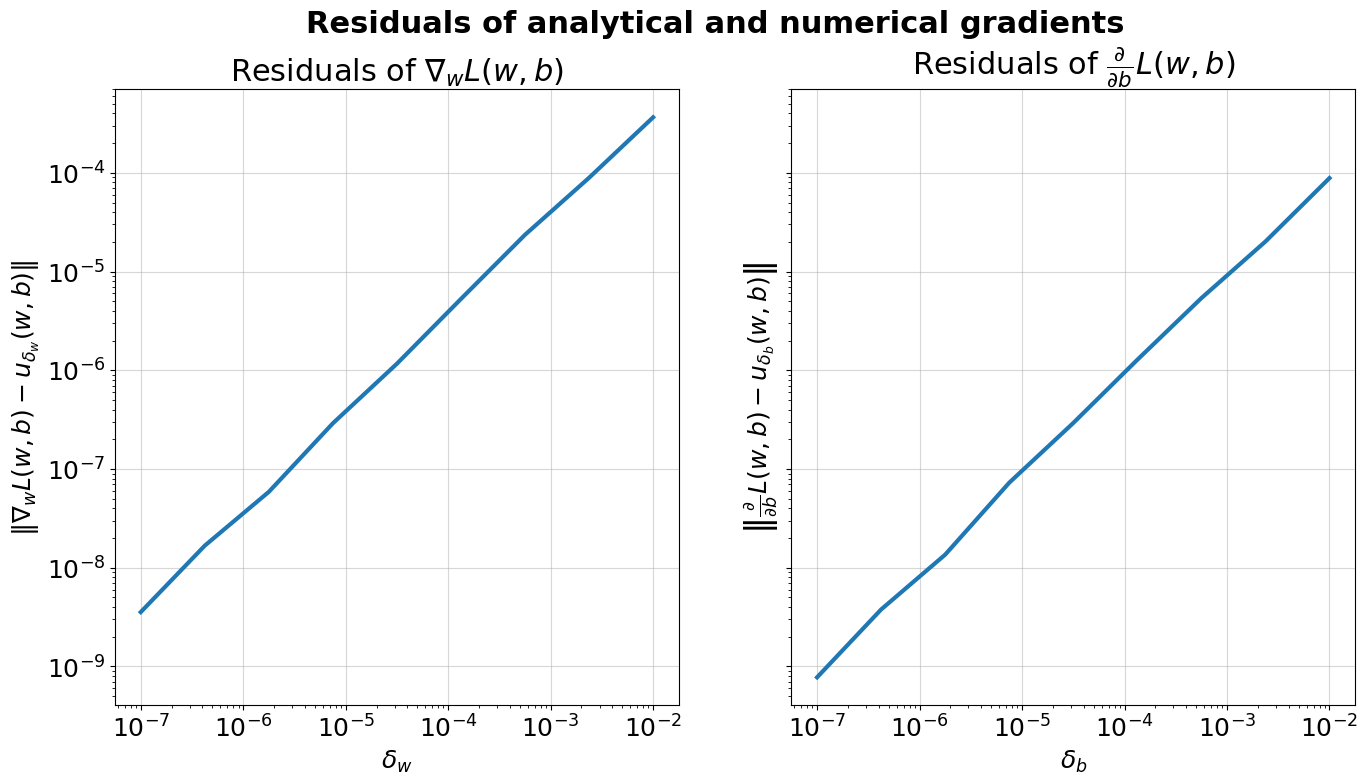

In [5]:
partial_train, partial_test = train_test_split(
    prepared_train_set, random_state=randomness, test_size=0.2
)
partial_train_X = partial_train.drop("contamination_level", axis=1).values
partial_train_y = partial_train["contamination_level"].values
compare_gradients(partial_train_X, partial_train_y, deltas=np.logspace(-7, -2, 9), huber_delta=0.1)

## Test LR

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def test_lr(X_train, y_train, X_val, y_val, huber_delta: float, title: str, max_iter: int = 1500):
    lr_list = np.logspace(-9, -1, 9)

    fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
    plt.suptitle(title, fontsize=32)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.9)

    axs = np.ravel(axs)
    for i, lr in enumerate(lr_list):
        cur_linear_reggressor = LinearRegressor(lr, huber_delta)
        train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter=max_iter)
        print("lr size = " + str(lr) + ", Best train loss = " + str(min(train_losses)) + ", Best validation loss = " + str(min(val_losses)))

        iterations = np.arange(max_iter + 1)
        axs[i].semilogy(iterations, train_losses, label="Train")
        axs[i].semilogy(iterations, val_losses, label="Validation")
        axs[i].grid(alpha=0.5)
        axs[i].legend()
        axs[i].set_title("lr = " + str(lr))
        axs[i].set_xlabel("iteration")
        axs[i].set_ylabel("Huber Error")

## Q5

In [10]:
# Q3 - psuedo is dead.
# Train model using delta s.t. it behaves like square loss, by choosing a large value for it
delta = 100
model = LinearRegressor(lr=0.01, huber_delta=100)
model.fit(partial_train_X, partial_train_y)
residuals = partial_train_y - model.predict(partial_train_X)
residuals = np.abs(residuals)

quantile_thresholds = [0.5, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
deltas = list(np.quantile(residuals, quantile_thresholds))

from sklearn.model_selection import cross_validate

test_cv_scores = []
train_cv_scores = []
best_score = 0
best_delta = 0
print(f"testing delta: {deltas}")
for delta in deltas:
    model = LinearRegressor(lr=0.01, huber_delta=delta)

    scores = cross_validate(model, partial_train_X, partial_train_y, cv=8, return_train_score=True, n_jobs=8)
    test_cv_scores.append(np.mean(scores["test_score"]))
    train_cv_scores.append(np.mean(scores["train_score"]))

best_delta = deltas[np.argmax(test_cv_scores)]
print(f"train_cv_scores: {train_cv_scores}")
print(f"test_cv_scores: {test_cv_scores}")
print(f"Best delta: {best_delta}, corresponds to quantile: {quantile_thresholds[np.argmax(test_cv_scores)]}")

testing delta: [0.18419942331227357, 0.30795498667207205, 0.3899666339178698, 0.5377854908086316, 0.7109592907708525, 0.7844538386109053, 0.8596163885282744, 0.9993534409276823, 1.1826425977061266, 1.4647186757709123]
train_cv_scores: [0.1692921019696872, 0.22255647105407167, 0.24423790098025594, 0.26815843902949926, 0.28062146198719484, 0.2833350425321842, 0.2852136599729082, 0.2870547011519197, 0.2878521550374802, 0.28804160427105463]
test_cv_scores: [0.11409847908552821, 0.17033041527210574, 0.19149535178085697, 0.21154717051490285, 0.2205255957264204, 0.22169151645012417, 0.22215831901021937, 0.22201284436671445, 0.2211028297325261, 0.2207752343832844]
Best delta: 0.8596163885282744, corresponds to quantile: 0.97


0.8596163885282744
lr size = 9.999999999999999e-10, Best train loss = 0.3722289546118988, Best validation loss = 0.3842991569479859
lr size = 1e-08, Best train loss = 0.3722073896119742, Best validation loss = 0.3842761786852191
lr size = 1e-07, Best train loss = 0.37199177434998487, Best validation loss = 0.38404643270728556
lr size = 1e-06, Best train loss = 0.3698390902296621, Best validation loss = 0.38175266860055684
lr size = 9.999999999999999e-06, Best train loss = 0.3486575264348838, Best validation loss = 0.3591825387966132
lr size = 9.999999999999999e-05, Best train loss = 0.1942040268351951, Best validation loss = 0.19449548026350905
lr size = 0.001, Best train loss = 0.07250155039176114, Best validation loss = 0.0702500047789567
lr size = 0.01, Best train loss = 0.057577794028007646, Best validation loss = 0.049156592665595314
lr size = 0.09999999999999999, Best train loss = 0.05646150104452514, Best validation loss = 0.044829973864918146


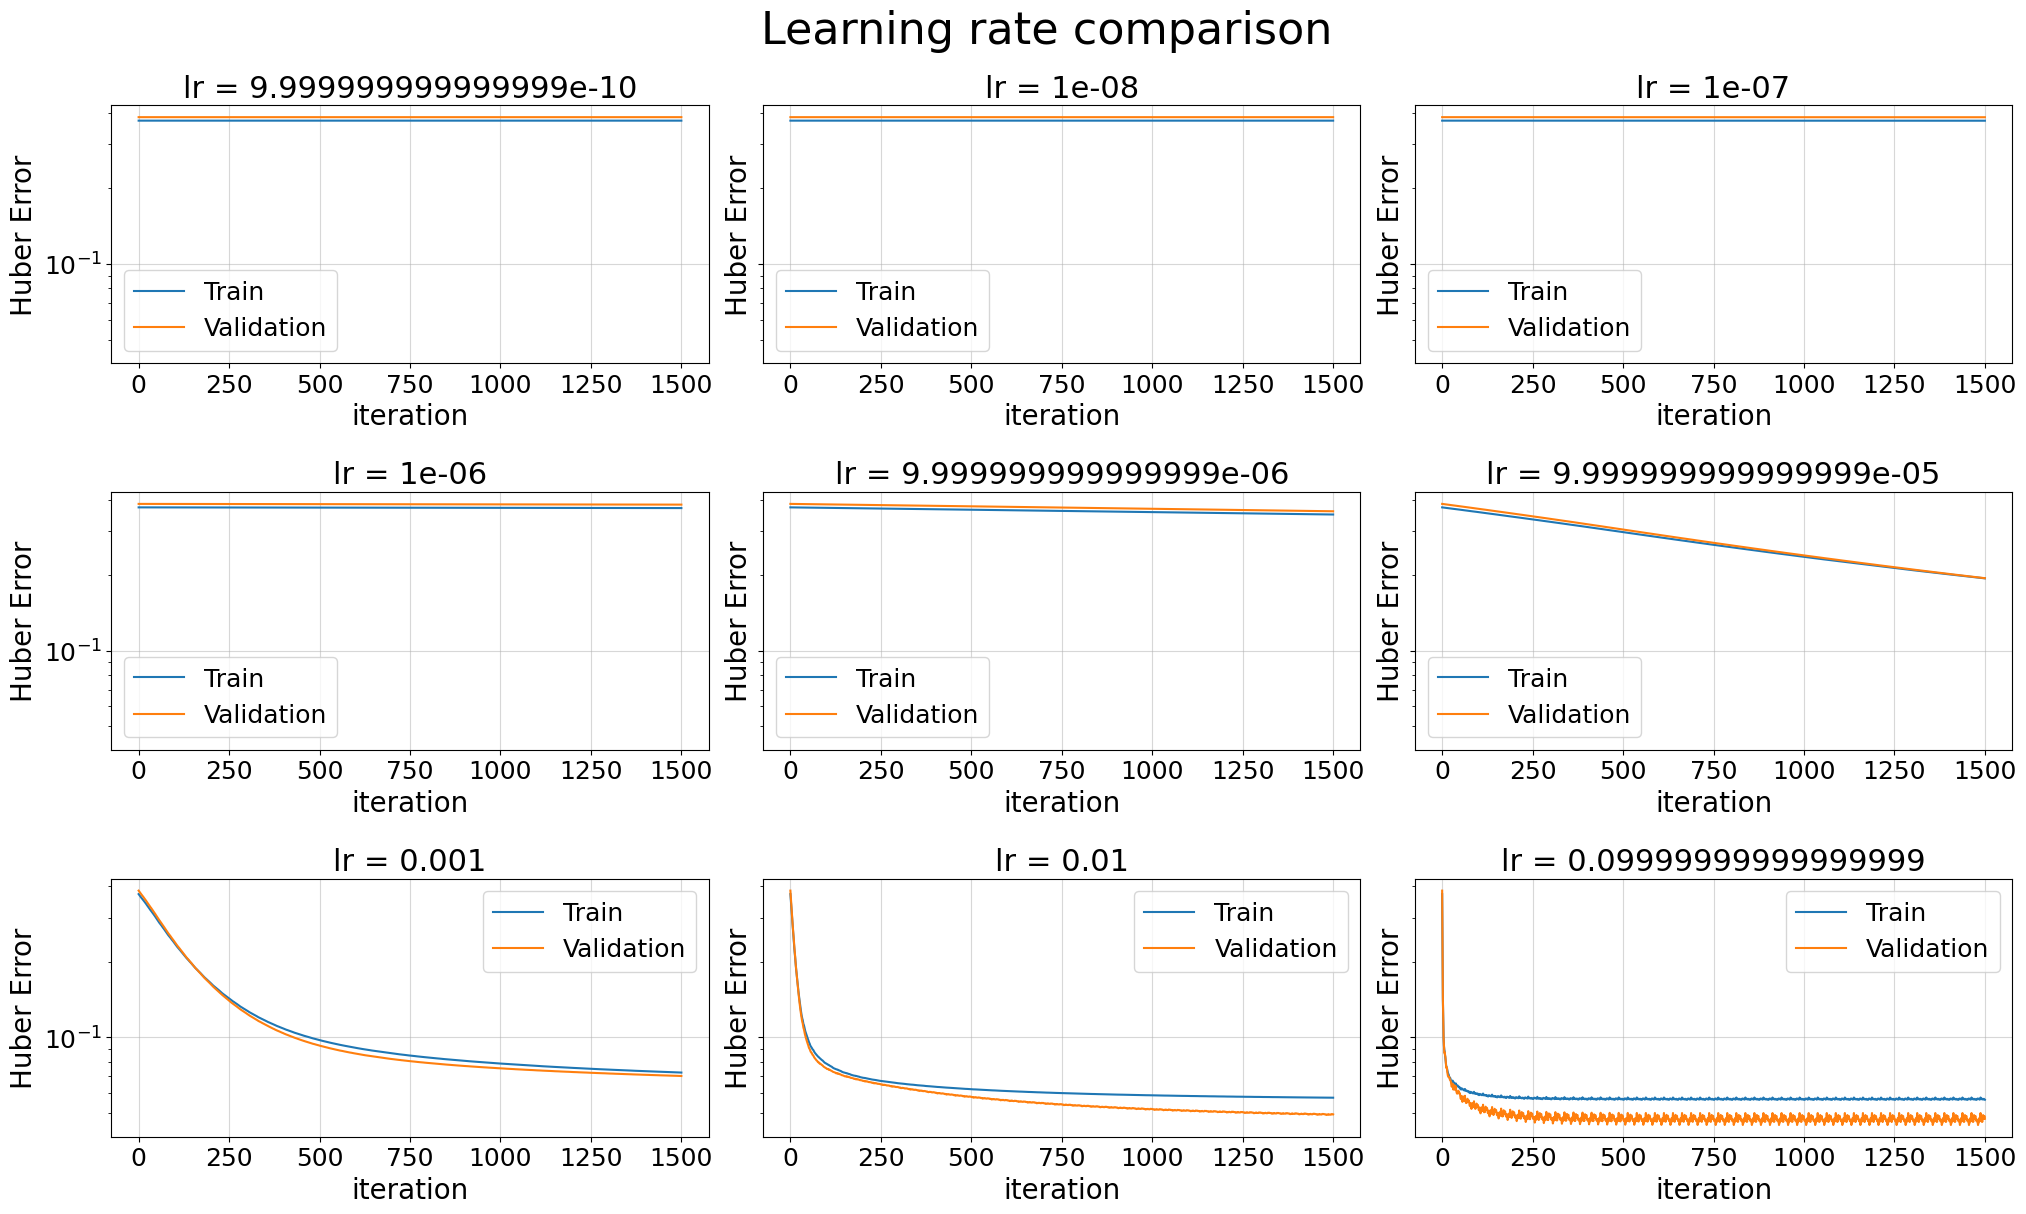

In [11]:
delta = best_delta # from previous cell
print(delta)
test_lr(
    partial_train_X,
    partial_train_y,
    partial_test.drop("contamination_level", axis=1).values,
    partial_test["contamination_level"].values,
    huber_delta=delta,
    title="Learning rate comparison",
)

# Section 2

## Q7

In [ ]:
# Q7
prepared_X = prepared_train_set.drop("contamination_level", axis=1)
prepared_y = prepared_train_set["contamination_level"]
from sklearn.dummy import DummyRegressor


dummy = DummyRegressor(strategy="mean")
scores = cross_validate(dummy, prepared_X, prepared_y, cv=5, return_train_score=True, n_jobs=5, scoring="neg_mean_squared_error")
dummy_test_score = np.mean(scores["test_score"])
dummy_train_score = np.mean(scores["train_score"])

print(f"Training   score for Dummy: {dummy_train_score}")
print(f"Validation score for Dummy: {dummy_test_score}")
print(f"Actual mean value:          {prepared_y.mean()}")
dummy.fit(prepared_X, prepared_y)  # <-- Saved for future use

## Q8

# Section 3

## Q345

## Q346

## Q347

# IML Major HW 3 - Linear Regression
| Name | ID |
|------|----|
| Daniel Gershkovich   | 209088723  |
| Assaf Alon   | 207376807  |

In [ ]:
df = pd.read_csv("data_HW3.csv")
ASSAF_ID = 207376807
DANIEL_ID = 209088723
randomness = ASSAF_ID % 100 + DANIEL_ID % 100
train_set, test_set = train_test_split(
    df, random_state=randomness, test_size=0.2
)
prepared_train_set = prepare_data(train_set, train_set)
prepared_test_set = prepare_data(train_set, test_set)